In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
print(f'TneosorFlow Version: {tf.__version__}')

TneosorFlow Version: 2.3.0


# Setup

## Download the flower dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

PosixPath('/home/kdd/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
data_dir.glob('*')

<generator object Path.glob at 0x7f45ffdbd430>

In [6]:
for i in data_dir.glob('*'):
    print(i)

/home/kdd/.keras/datasets/flower_photos/LICENSE.txt
/home/kdd/.keras/datasets/flower_photos/roses
/home/kdd/.keras/datasets/flower_photos/daisy
/home/kdd/.keras/datasets/flower_photos/sunflowers
/home/kdd/.keras/datasets/flower_photos/tulips
/home/kdd/.keras/datasets/flower_photos/dandelion


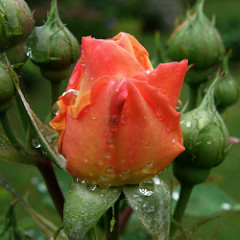

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [8]:
roses[0]

PosixPath('/home/kdd/.keras/datasets/flower_photos/roses/2501297526_cbd66a3f7e_m.jpg')

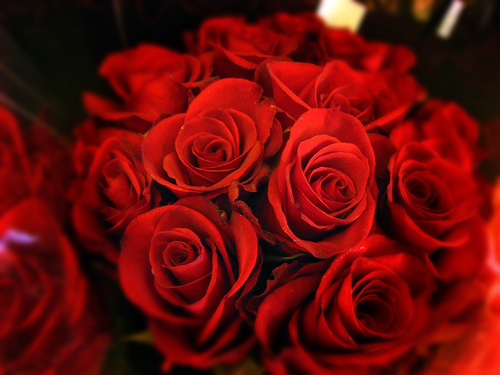

In [9]:
PIL.Image.open(str(roses[1]))

# Load using keras.preprocessing

## Create a dataset

In [10]:
batch_size = 32
img_height = img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             validation_split=0.2,
                                                             subset='validation',
                                                             seed=123,
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
val_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

In [15]:
import matplotlib.pyplot as plt

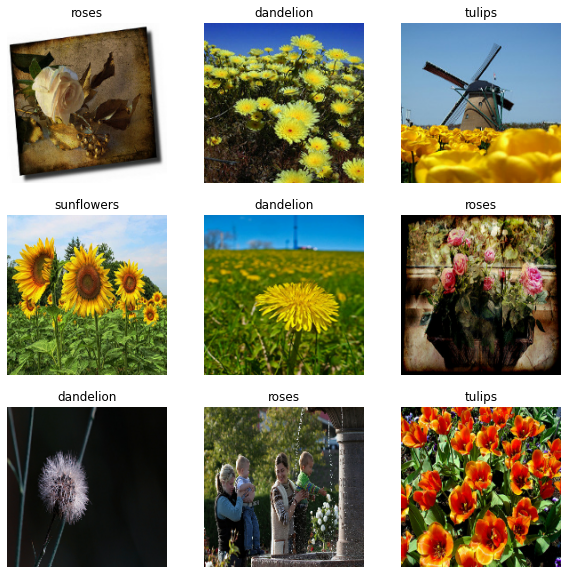

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [17]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Standardize the data

In [18]:
from tensorflow.keras import layers

In [19]:
# Note: If you would like to scale pixel values to [-1,1] you can instead write Rescaling(1./127.5, offset=-1)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
# Apply normalization to the dataset by calling map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


## Configure the dataset for performance

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a model

In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
 7/92 [=>............................] - ETA: 1:30 - loss: 1.8098 - accuracy: 0.2277